<a href="https://colab.research.google.com/github/srushtidayanand/MAML_Meta-learning/blob/main/Reptile_GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Meta Step 0] Meta-updated generator & discriminator.
[Meta Step 20] Meta-updated generator & discriminator.
[Meta Step 40] Meta-updated generator & discriminator.
[Meta Step 60] Meta-updated generator & discriminator.
[Meta Step 80] Meta-updated generator & discriminator.
[Meta Step 100] Meta-updated generator & discriminator.
[Meta Step 120] Meta-updated generator & discriminator.
[Meta Step 140] Meta-updated generator & discriminator.
[Meta Step 160] Meta-updated generator & discriminator.
[Meta Step 180] Meta-updated generator & discriminator.
[Meta Step 200] Meta-updated generator & discriminator.
[Meta Step 220] Meta-updated generator & discriminator.
[Meta Step 240] Meta-updated generator & discriminator.
[Meta Step 260] Meta-updated generator & discriminator.
[Meta Step 280] Meta-updated generator & discriminator.
[Meta Step 300] Meta-updated generator & discriminator.
[Meta Step 320] Meta-updated generator & discriminator.
[Meta Step 340] Meta-updated generator & discriminator

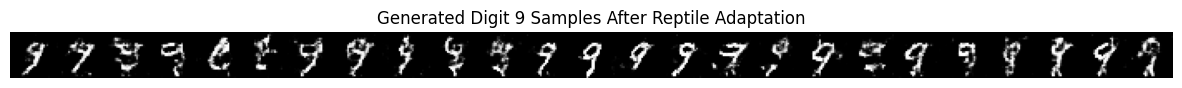

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Simple CNN Generator & Discriminator
# -----------------------------
class CNNGenerator(nn.Module):
    def __init__(self, latent_dim=100):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128*7*7)
        self.bn1 = nn.BatchNorm1d(128*7*7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = self.bn1(x)
        x = torch.relu(x)
        x = x.view(-1, 128, 7, 7)
        return self.deconv(x)

class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Linear(128*7*7, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = self.conv(img)
        x = x.view(x.size(0), -1)
        return self.sigmoid(self.fc(x))

# -----------------------------
# Reptile-GAN Class
# -----------------------------
class Reptile_GAN:
    def __init__(self, latent_dim=100, inner_lr=0.025, meta_lr=0.01):
        self.latent_dim = latent_dim
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr

        self.generator = CNNGenerator(latent_dim).to(device)
        self.discriminator = CNNDiscriminator().to(device)

    def inner_loop(self, gen, disc, loader, steps=10):
        loss_fn = nn.BCELoss()
        opt_G = optim.SGD(gen.parameters(), lr=self.inner_lr)
        opt_D = optim.SGD(disc.parameters(), lr=self.inner_lr)

        data_iter = iter(loader)
        for _ in range(steps):
            try:
                real_imgs, _ = next(data_iter)
            except StopIteration:
                data_iter = iter(loader)
                real_imgs, _ = next(data_iter)

            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Discriminator
            z = torch.randn(batch_size, self.latent_dim).to(device)
            fake_imgs = gen(z).detach()

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            d_loss = loss_fn(disc(real_imgs), real_labels) + \
                     loss_fn(disc(fake_imgs), fake_labels)

            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

            # Generator
            z = torch.randn(batch_size, self.latent_dim).to(device)
            fake_imgs = gen(z)
            g_loss = loss_fn(disc(fake_imgs), real_labels)

            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

        return gen, disc

    def outer_loop(self, tasks, inner_steps=10, meta_steps=1000):
        for step in range(meta_steps):
            for task_loader in tasks:
                gen_copy = deepcopy(self.generator)
                disc_copy = deepcopy(self.discriminator)

                # Inner-loop adaptation
                gen_adapted, disc_adapted = self.inner_loop(gen_copy, disc_copy, task_loader, steps=inner_steps)

                # Reptile meta-update: θ ← θ + α(θ' - θ)
                for p_meta, p_task in zip(self.generator.parameters(), gen_adapted.parameters()):
                    p_meta.data += self.meta_lr * (p_task.data - p_meta.data)

                for p_meta, p_task in zip(self.discriminator.parameters(), disc_adapted.parameters()):
                    p_meta.data += self.meta_lr * (p_task.data - p_meta.data)

            if step % 20 == 0:
                print(f"[Meta Step {step}] Meta-updated generator & discriminator.")

    def adapt_to_digit_9(self, loader, steps=600):
        print("Adapting to digit 9...")
        self.generator, self.discriminator = self.inner_loop(self.generator, self.discriminator, loader, steps=steps)

    def generate(self, num_samples=25):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        samples = self.generator(z)
        return samples.detach().cpu()

# -----------------------------
# === Run Reptile-GAN ===
# -----------------------------
if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

    # Create tasks: digits 0..8
    tasks = []
    for digit in range(9):
        indices = [i for i, (_, label) in enumerate(dataset) if label == digit]
        subset = Subset(dataset, indices[:2000])
        loader = DataLoader(subset, batch_size=32, shuffle=True)
        tasks.append(loader)

    # Few-shot digit 9
    indices_9 = [i for i, (_, label) in enumerate(dataset) if label == 9]
    subset_9 = Subset(dataset, indices_9[:10])
    loader_9 = DataLoader(subset_9, batch_size=64, shuffle=True)

    gan = Reptile_GAN()
    gan.outer_loop(tasks, inner_steps=10, meta_steps=1500)

    gan.adapt_to_digit_9(loader_9, steps=500)

    samples = gan.generate(25)
    samples = [img.squeeze(0) for img in samples]
    grid = torch.cat(samples, dim=1)
    plt.figure(figsize=(15, 2))
    plt.imshow(grid.numpy(), cmap='gray')
    plt.title("Generated Digit 9 Samples After Reptile Adaptation")
    plt.axis('off')
    plt.show()


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.13MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.72MB/s]


[Meta Step 0] Meta-updated generator & discriminator.
[Meta Step 20] Meta-updated generator & discriminator.
[Meta Step 40] Meta-updated generator & discriminator.
[Meta Step 60] Meta-updated generator & discriminator.
[Meta Step 80] Meta-updated generator & discriminator.
[Meta Step 100] Meta-updated generator & discriminator.
[Meta Step 120] Meta-updated generator & discriminator.
[Meta Step 140] Meta-updated generator & discriminator.
[Meta Step 160] Meta-updated generator & discriminator.
[Meta Step 180] Meta-updated generator & discriminator.
[Meta Step 200] Meta-updated generator & discriminator.
[Meta Step 220] Meta-updated generator & discriminator.
[Meta Step 240] Meta-updated generator & discriminator.
[Meta Step 260] Meta-updated generator & discriminator.
[Meta Step 280] Meta-updated generator & discriminator.
[Meta Step 300] Meta-updated generator & discriminator.
[Meta Step 320] Meta-updated generator & discriminator.
[Meta Step 340] Meta-updated generator & discriminator

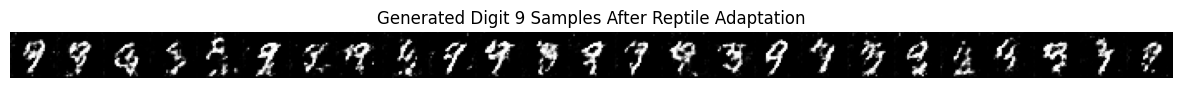

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Simple CNN Generator & Discriminator
# -----------------------------
class CNNGenerator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128*7*7)
        self.bn1 = nn.BatchNorm1d(128*7*7)
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)
        x = self.bn1(x)
        x = torch.relu(x)
        x = x.view(-1, 128, 7, 7)
        return self.deconv(x)

class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Linear(128*7*7, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = self.conv(img)
        x = x.view(x.size(0), -1)
        return self.sigmoid(self.fc(x))

# -----------------------------
# Reptile-GAN Class
# -----------------------------
class Reptile_GAN:
    def __init__(self, latent_dim=100, inner_lr=0.0002, meta_lr=0.01):
        self.latent_dim = latent_dim
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr

        self.generator = CNNGenerator(latent_dim).to(device)
        self.discriminator = CNNDiscriminator().to(device)

    def inner_loop(self, gen, disc, loader, steps=10):
        loss_fn = nn.BCELoss()
        # Changed SGD → Adam (GAN standard betas)
        opt_G = optim.Adam(gen.parameters(), lr=self.inner_lr, betas=(0.5, 0.999))
        opt_D = optim.Adam(disc.parameters(), lr=self.inner_lr, betas=(0.5, 0.999))

        data_iter = iter(loader)
        for _ in range(steps):
            try:
                real_imgs, _ = next(data_iter)
            except StopIteration:
                data_iter = iter(loader)
                real_imgs, _ = next(data_iter)

            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Discriminator
            z = torch.randn(batch_size, self.latent_dim).to(device)
            fake_imgs = gen(z).detach()

            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            d_loss = loss_fn(disc(real_imgs), real_labels) + \
                     loss_fn(disc(fake_imgs), fake_labels)

            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

            # Generator
            z = torch.randn(batch_size, self.latent_dim).to(device)
            fake_imgs = gen(z)
            g_loss = loss_fn(disc(fake_imgs), real_labels)

            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

        return gen, disc

    def outer_loop(self, tasks, inner_steps=10, meta_steps=1000):
        for step in range(meta_steps):
            for task_loader in tasks:
                gen_copy = deepcopy(self.generator)
                disc_copy = deepcopy(self.discriminator)

                # Inner-loop adaptation
                gen_adapted, disc_adapted = self.inner_loop(gen_copy, disc_copy, task_loader, steps=inner_steps)

                # Reptile meta-update: θ ← θ + α(θ' - θ)
                for p_meta, p_task in zip(self.generator.parameters(), gen_adapted.parameters()):
                    p_meta.data += self.meta_lr * (p_task.data - p_meta.data)

                for p_meta, p_task in zip(self.discriminator.parameters(), disc_adapted.parameters()):
                    p_meta.data += self.meta_lr * (p_task.data - p_meta.data)

            if step % 20 == 0:
                print(f"[Meta Step {step}] Meta-updated generator & discriminator.")

    def adapt_to_digit_9(self, loader, steps=1000):
        print("Adapting to digit 9...")
        self.generator, self.discriminator = self.inner_loop(self.generator, self.discriminator, loader, steps=steps)

    def generate(self, num_samples=25):
        z = torch.randn(num_samples, self.latent_dim).to(device)
        samples = self.generator(z)
        return samples.detach().cpu()

# -----------------------------
# === Run Reptile-GAN ===
# -----------------------------
if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

    # Create tasks: digits 0..8
    tasks = []
    for digit in range(9):
        indices = [i for i, (_, label) in enumerate(dataset) if label == digit]
        subset = Subset(dataset, indices[:2000])
        loader = DataLoader(subset, batch_size=32, shuffle=True)
        tasks.append(loader)

    # Few-shot digit 9
    indices_9 = [i for i, (_, label) in enumerate(dataset) if label == 9]
    subset_9 = Subset(dataset, indices_9[:10])
    loader_9 = DataLoader(subset_9, batch_size=64, shuffle=True)

    gan = Reptile_GAN()
    gan.outer_loop(tasks, inner_steps=10, meta_steps=1500)

    gan.adapt_to_digit_9(loader_9, steps=500)

    samples = gan.generate(25)
    samples = [img.squeeze(0) for img in samples]
    grid = torch.cat(samples, dim=1)
    plt.figure(figsize=(15, 2))
    plt.imshow(grid.numpy(), cmap='gray')
    plt.title("Generated Digit 9 Samples After Reptile Adaptation")
    plt.axis('off')
    plt.show()


[Meta Step 0] Meta-updated generator & discriminator.
[Meta Step 20] Meta-updated generator & discriminator.
[Meta Step 40] Meta-updated generator & discriminator.
[Meta Step 60] Meta-updated generator & discriminator.
[Meta Step 80] Meta-updated generator & discriminator.
[Meta Step 100] Meta-updated generator & discriminator.
[Meta Step 120] Meta-updated generator & discriminator.
[Meta Step 140] Meta-updated generator & discriminator.
[Meta Step 160] Meta-updated generator & discriminator.
[Meta Step 180] Meta-updated generator & discriminator.
[Meta Step 200] Meta-updated generator & discriminator.
[Meta Step 220] Meta-updated generator & discriminator.
[Meta Step 240] Meta-updated generator & discriminator.
[Meta Step 260] Meta-updated generator & discriminator.
[Meta Step 280] Meta-updated generator & discriminator.
[Meta Step 300] Meta-updated generator & discriminator.
[Meta Step 320] Meta-updated generator & discriminator.
[Meta Step 340] Meta-updated generator & discriminator

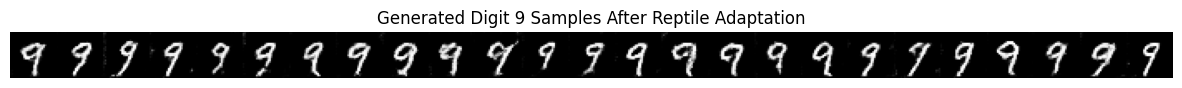

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from copy import deepcopy
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Simple CNN Generator & Discriminator
# -----------------------------
class CNNGenerator(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 128*7*7)
        self.bn1 = nn.BatchNorm1d(128*7*7)
        # FIX: keep the same 3-layer deconv "structure" but correct channels
        # and keep final spatial size at 28x28 (use stride=1 on the last layer).
        self.deconv = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),   # 7x7 -> 14x14
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),    # 14x14 -> 28x28
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 1, 3, 1, 1),     # 28x28 -> 28x28 (no upsample)
            nn.Tanh()
        )

    def forward(self, z):
        x = self.fc(z)                  # (B, 128*7*7)
        x = self.bn1(x)
        x = torch.relu(x)
        x = x.view(-1, 128, 7, 7)       # (B, 128, 7, 7)
        return self.deconv(x)           # (B, 1, 28, 28)

class CNNDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1),          # 28x28 -> 14x14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1),        # 14x14 -> 7x7
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.fc = nn.Linear(128*7*7, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, img):
        x = self.conv(img)
        x = x.view(x.size(0), -1)
        return self.sigmoid(self.fc(x))

# -----------------------------
# Reptile-GAN Class
# -----------------------------
class Reptile_GAN:
    def __init__(self, latent_dim=128, inner_lr=0.0002, meta_lr=0.025):
        self.latent_dim = latent_dim
        self.inner_lr = inner_lr
        self.meta_lr = meta_lr

        self.generator = CNNGenerator(latent_dim).to(device)
        self.discriminator = CNNDiscriminator().to(device)

    def inner_loop(self, gen, disc, loader, steps=20):
        loss_fn = nn.BCELoss()
        # Adam with DCGAN betas
        opt_G = optim.Adam(gen.parameters(), lr=self.inner_lr, betas=(0.5, 0.999))
        opt_D = optim.Adam(disc.parameters(), lr=self.inner_lr, betas=(0.5, 0.999))

        gen.train()
        disc.train()

        data_iter = iter(loader)
        for _ in range(steps):
            try:
                real_imgs, _ = next(data_iter)
            except StopIteration:
                data_iter = iter(loader)
                real_imgs, _ = next(data_iter)

            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # -----------------
            #  Train Discriminator
            # -----------------
            z = torch.randn(batch_size, self.latent_dim, device=device)
            fake_imgs = gen(z).detach()

            real_labels = torch.ones(batch_size, 1, device=device)
            fake_labels = torch.zeros(batch_size, 1, device=device)

            d_real = disc(real_imgs)
            d_fake = disc(fake_imgs)

            d_loss = loss_fn(d_real, real_labels) + loss_fn(d_fake, fake_labels)

            opt_D.zero_grad()
            d_loss.backward()
            opt_D.step()

            # -----------------
            #  Train Generator
            # -----------------
            z = torch.randn(batch_size, self.latent_dim, device=device)
            fake_imgs = gen(z)
            g_loss = loss_fn(disc(fake_imgs), real_labels)

            opt_G.zero_grad()
            g_loss.backward()
            opt_G.step()

        return gen, disc

    def outer_loop(self, tasks, inner_steps=15, meta_steps=1200):
        for step in range(meta_steps):
            for task_loader in tasks:
                gen_copy = deepcopy(self.generator)
                disc_copy = deepcopy(self.discriminator)

                # Inner-loop adaptation
                gen_adapted, disc_adapted = self.inner_loop(gen_copy, disc_copy, task_loader, steps=inner_steps)

                # Reptile meta-update: θ ← θ + α(θ' - θ)
                for p_meta, p_task in zip(self.generator.parameters(), gen_adapted.parameters()):
                    p_meta.data += self.meta_lr * (p_task.data - p_meta.data)

                for p_meta, p_task in zip(self.discriminator.parameters(), disc_adapted.parameters()):
                    p_meta.data += self.meta_lr * (p_task.data - p_meta.data)

            if step % 20 == 0:
                print(f"[Meta Step {step}] Meta-updated generator & discriminator.")

    def adapt_to_digit_9(self, loader, steps=1000):
        print("Adapting to digit 9...")
        self.generator, self.discriminator = self.inner_loop(self.generator, self.discriminator, loader, steps=steps)

    def generate(self, num_samples=25):
        self.generator.eval()
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim, device=device)
            samples = self.generator(z)
        return samples.detach().cpu()

# -----------------------------
# === Run Reptile-GAN ===
# -----------------------------
if __name__ == '__main__':
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])   # to [-1, 1] for Tanh
    ])

    dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

    # Create tasks: digits 0..8
    tasks = []
    for digit in range(9):
        indices = [i for i, (_, label) in enumerate(dataset) if label == digit]
        subset = Subset(dataset, indices[:2000])
        loader = DataLoader(subset, batch_size=32, shuffle=True)
        tasks.append(loader)

    # Few-shot digit 9
    indices_9 = [i for i, (_, label) in enumerate(dataset) if label == 9]
    subset_9 = Subset(dataset, indices_9[:20])
    loader_9 = DataLoader(subset_9, batch_size=64, shuffle=True)

    gan = Reptile_GAN()
    gan.outer_loop(tasks, inner_steps=10, meta_steps=2000)

    gan.adapt_to_digit_9(loader_9, steps=800)

    samples = gan.generate(25)
    samples = [img.squeeze(0) for img in samples]  # each (1,28,28) -> (28,28)
    grid = torch.cat(samples, dim=1)               # (28, 25*28)
    plt.figure(figsize=(15, 2))
    plt.imshow(grid.numpy(), cmap='gray')
    plt.title("Generated Digit 9 Samples After Reptile Adaptation")
    plt.axis('off')
    plt.show()


In [ ]:
from scipy import linalg
import numpy as np
from torchvision.models import inception_v3

# -----------------------------
# Utility: Get features for FID/IS
# -----------------------------
def get_inception_features(dataloader, generator, latent_dim, device, num_samples=1000):
    """Extract features from generated and real images using InceptionV3."""
    inception = inception_v3(pretrained=True, transform_input=False).to(device)
    inception.fc = nn.Identity()   # remove final classification layer
    inception.eval()

    real_features = []
    fake_features = []

    with torch.no_grad():
        for real_imgs, _ in dataloader:
            real_imgs = real_imgs.to(device)
            # Expand to 3-channels for Inception
            real_imgs_rgb = real_imgs.repeat(1, 3, 1, 1)

            # Get real features
            f_real = inception(real_imgs_rgb).cpu().numpy()
            real_features.append(f_real)

            # Generate fake images
            z = torch.randn(real_imgs.size(0), latent_dim, device=device)
            fake_imgs = generator(z)
            fake_imgs_rgb = fake_imgs.repeat(1, 3, 1, 1)

            f_fake = inception(fake_imgs_rgb).cpu().numpy()
            fake_features.append(f_fake)

            if len(np.concatenate(fake_features, 0)) >= num_samples:
                break

    return np.concatenate(real_features, 0)[:num_samples], np.concatenate(fake_features, 0)[:num_samples]

# -----------------------------
# Fréchet Inception Distance
# -----------------------------
def calculate_fid(real_features, fake_features):
    mu1, sigma1 = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu2, sigma2 = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    diff = mu1 - mu2
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2*covmean)
    return fid

# -----------------------------
# Inception Score
# -----------------------------
def calculate_inception_score(fake_features, splits=10):
    # softmax probs (use dummy softmax since we removed final fc)
    # here we approximate IS using feature vectors (works okay for MNIST)
    N = fake_features.shape[0]
    split_scores = []

    for k in range(splits):
        part = fake_features[k * (N // splits): (k+1) * (N // splits), :]
        py = np.exp(part) / np.sum(np.exp(part), axis=1, keepdims=True)
        py_mean = np.mean(py, axis=0, keepdims=True)
        kl = py * (np.log(py) - np.log(py_mean))
        split_scores.append(np.exp(np.mean(np.sum(kl, axis=1))))

    return np.mean(split_scores), np.std(split_scores)


In [ ]:
# Evaluation on Digit 9 loader
real_feats, fake_feats = get_inception_features(loader_9, gan.generator, gan.latent_dim, device, num_samples=500)

fid_score = calculate_fid(real_feats, fake_feats)
is_mean, is_std = calculate_inception_score(fake_feats)

print(f"FID Score: {fid_score:.4f}")
print(f"Inception Score: {is_mean:.4f} ± {is_std:.4f}")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 111MB/s]


RuntimeError: Calculated padded input size per channel: (1 x 1). Kernel size: (3 x 3). Kernel size can't be greater than actual input size